In [75]:
from phimal_utilities.analysis import Results, load_tensorboard

from phimal_utilities.data import Dataset
from phimal_utilities.data.burgers import BurgersDelta

import numpy as np
import os
from natsort import natsorted

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
sns.set()

%config InlineBackend.figure_format = 'svg'

sns.set_context('paper')
sns.set_style('white')

In [47]:
def correct_eq(found_coeffs, correct_coeffs):
    active_terms = np.where(np.abs(found_coeffs) > 0, 1, 0)
    correct_eqs = np.sum(active_terms - correct_coeffs, axis=1) == 0
    return correct_eqs

# Paper plot

In [49]:
# Making dataset
v = 0.1
A = 1.0

x = np.linspace(-3, 4, 500)
t = np.linspace(0.5, 5.0, 50)
x_grid, t_grid = np.meshgrid(x, t, indexing='ij')
dataset = Dataset(BurgersDelta, v=v, A=A)

X_full, y = dataset.create_dataset(x_grid.reshape(-1, 1), t_grid.reshape(-1, 1), n_samples=0, noise=0, random=False, normalize=False)
y_true = y.reshape(x_grid.shape)

X, y_noisy = dataset.create_dataset(x_grid.reshape(-1, 1), t_grid.reshape(-1, 1), n_samples=1000, noise=0.6, random=True, normalize=False)

In [59]:
# Loading pretrained network

import torch
from deepymod_torch import DeepMoD
from deepymod_torch.model.func_approx import NN
from deepymod_torch.model.library import Library1D
from deepymod_torch.model.constraint import LeastSquares
from deepymod_torch.model.sparse_estimators import PDEFIND

network = NN(2, [30, 30, 30, 30, 30], 1)
library = Library1D(poly_order=2, diff_order=3) # Library function
estimator = PDEFIND(lam=1e-4) # Sparse estimator 
constraint = LeastSquares() # How to constrain
model = DeepMoD(network, library, estimator, constraint)
model.load_state_dict(torch.load('single_0.6/trained_model.pt'))

y_predict = model(X_full)[0].detach().cpu().numpy().reshape(x_grid.shape)

In [43]:
# Loading files from pde find
files = natsorted([file for file in os.listdir('pdefind/data_delta_lam_1e-4//')])
df_pde = [load_tensorboard(f'pdefind/data_delta_lam_1e-4//{file}') for file in files]

keys = Results('pdefind/data_delta/noise_0.0_run_0/').keys 
noise = np.array([file.split('_')[1] for file in files]) # getting noise levels

final_coeffs_pde = np.concatenate([df[keys['coeffs']].tail(1).to_numpy() for df in df_pde], axis=0)

correct_coeffs = np.zeros((12))
correct_coeffs[2] = 1
correct_coeffs[5] = 1

correct_pde = correct_eq(final_coeffs_pde, correct_coeffs)
fraction_correct_pde = correct_pde.reshape(-1, 5).mean(axis=1)

In [44]:
# Loading files from threshold
files = natsorted([file for file in os.listdir('threshold/data_delta/')])
df_thr = [load_tensorboard(f'threshold/data_delta/{file}') for file in files]

noise = [file.split('_')[1] for file in files] # getting noise levels

final_coeffs_thr = np.concatenate([df[keys['coeffs']].tail(1).to_numpy() for df in df_thr], axis=0)
correct_thr = correct_eq(final_coeffs_thr, correct_coeffs)
fraction_correct_thr = correct_thr.reshape(-1, 5).mean(axis=1)

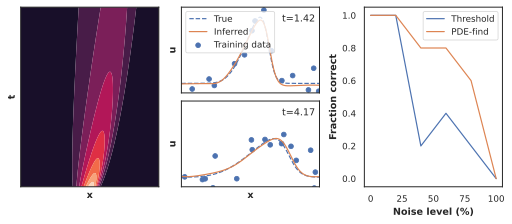

In [129]:
fig = plt.figure(constrained_layout=True, figsize=(7, 3))
gs = GridSpec(2, 3, figure=fig)


# Left
ax = fig.add_subplot(gs[:, 0])
ax.contourf(x_grid, t_grid, y_true, )
ax.set_xlabel('x', weight='bold')
ax.set_ylabel('t', weight='bold')
ax.set_xticks([])
ax.set_yticks([])

# Upper middle
ax = fig.add_subplot(gs[0, 1])
frame_1 = 10
x_plot = X[X[:, 0] == t[frame_1], 1]
y_plot = y_noisy[X[:, 0] == t[frame_1], 0]

ax.scatter(x_plot, y_plot, label='Training data')
ax.plot(x, y_true[:, frame_1], '--', label='True')
ax.plot(x, y_predict[:, frame_1], label='Inferred')

#ax.set_xlabel('x', weight='bold')
ax.set_ylabel('u', weight='bold')
ax.legend(loc='upper left')
ax.set_xlim([-3, 4])
ax.set_ylim([-0.1, 0.8])
ax.set_xticks([])
ax.set_yticks([])
ax.text(2.1, 0.65, f't={t[frame_1]:.2f}', )

# Lower middle
ax = fig.add_subplot(gs[1, 1])
frame_1 = 40
x_plot = X[X[:, 0] == t[frame_1], 1]
y_plot = y_noisy[X[:, 0] == t[frame_1], 0]

ax.scatter(x_plot, y_plot, label='Training data')
ax.plot(x, y_true[:, frame_1], '--', label='True')
ax.plot(x, y_predict[:, frame_1], label='Inferred')

ax.set_xlabel('x', weight='bold')
ax.set_ylabel('u', weight='bold')
ax.set_xticks([])
ax.set_yticks([])
#ax.legend()
ax.set_xlim([-3, 4])
ax.set_ylim([-0.1, 0.8])
#ax.legend(loc='upper left')
ax.text(2.1, 0.65, f't={t[frame_1]:.2f}', )

# Noise panel
ax = fig.add_subplot(gs[:, 2])
ax.plot(np.arange(0.0, 110, 20), fraction_correct_thr, label='Threshold')
ax.plot(np.arange(0.0, 110, 20), fraction_correct_pde, label='PDE-find')

ax.legend()
ax.set_xlabel('Noise level (%)', weight='bold')
ax.set_ylabel('Fraction correct', weight='bold')


plt.savefig('burgers.pdf', bbox_inches='tight')
plt.show()

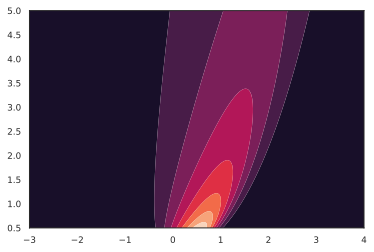

In [73]:
plt.contourf(x_grid, t_grid, y_true, )

In [18]:
plt.text('t = 0.0')

TypeError: text() missing 2 required positional arguments: 'y' and 's'

In [9]:
ax.legend()
ax.set_title('Train loss')
ax.set_ylim([-8.2, -3])
ax.set_xlabel('Epoch', weight='bold')
ax.set_ylabel('Log cost', weight='bold')

tensor([[7.1738e-21, 7.1074e-18, 1.0920e-15,  ..., 7.5641e-04, 8.1784e-04,
         8.8158e-04],
        [1.0917e-20, 1.0133e-17, 1.4845e-15,  ..., 7.9016e-04, 8.5363e-04,
         9.1944e-04],
        [1.6580e-20, 1.4424e-17, 2.0152e-15,  ..., 8.2524e-04, 8.9081e-04,
         9.5874e-04],
        ...,
        [2.0540e-33, 3.9071e-28, 2.8071e-24,  ..., 3.3152e-03, 3.8253e-03,
         4.3895e-03],
        [1.1754e-33, 2.4382e-28, 1.8663e-24,  ..., 3.1293e-03, 3.6148e-03,
         4.1524e-03],
        [6.7130e-34, 1.5190e-28, 1.2390e-24,  ..., 2.9531e-03, 3.4151e-03,
         3.9273e-03]])

# Checking separate things

In [40]:
# Loading files from pde find
files = natsorted([file for file in os.listdir('pdefind/data_delta_lam_1e-4//')])
df_pde = [load_tensorboard(f'pdefind/data_delta_lam_1e-4//{file}') for file in files]

keys = Results('pdefind/data_delta/noise_0.0_run_0/').keys 
noise = [file.split('_')[1] for file in files] # getting noise levels

final_coeffs_pde = np.concatenate([df[keys['coeffs']].tail(1).to_numpy() for df in df_pde], axis=0)

In [69]:
# Loading files from threshold
files = natsorted([file for file in os.listdir('threshold/data_delta/')])
df_thr = [load_tensorboard(f'threshold/data_delta/{file}') for file in files]

noise = [file.split('_')[1] for file in files] # getting noise levels

final_coeffs_thr = np.concatenate([df[keys['coeffs']].tail(1).to_numpy() for df in df_thr], axis=0)

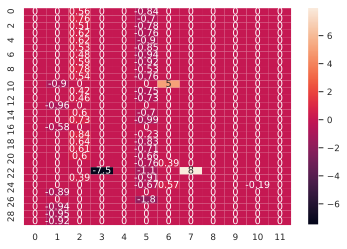

In [41]:
sns.heatmap(final_coeffs_pde, annot=True)

In [179]:
def correct_eq(found_coeffs, correct_coeffs):
    active_terms = np.where(np.abs(found_coeffs) > 0, 1, 0)
    correct_eqs = np.sum(active_terms - correct_coeffs, axis=1) == 0
    return correct_eqs

In [157]:
active_terms_pde = np.where(np.abs(final_coeffs_pde) > 0, 1, 0)
correct_eq = np.zeros((12))
correct_eq[2] = 1
correct_eq[5] = 1

In [ ]:
active_terms_pde - correct_eq

In [178]:
np.sum(active_terms_pde - correct_eq, axis=1) == 0

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True, False,  True,  True, False,  True,
        True,  True,  True, False, False,  True,  True, False, False,
       False, False, False])

In [167]:
np.sum(np.abs(active_terms_pde - correct_eq), axis=1)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 3., 0., 0., 3.,
       0., 0., 0., 0., 3., 3., 0., 0., 5., 3., 3., 3., 3.])

In [159]:
np.array_equiv(active_terms_pde, correct_eq)

False

In [163]:
np.count_nonzero(active_terms_pde == correct_eq, axis=1)

array([12, 12, 12, 12, 12, 12, 12, 12, 12, 12,  9, 12, 12,  9, 12, 12,  9,
       12, 12, 12, 12,  9,  9, 12, 12,  7,  9,  9,  9,  9])

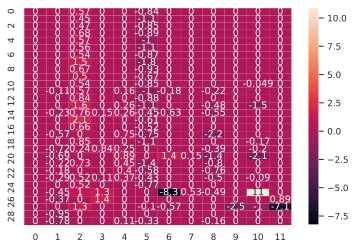

In [72]:
sns.heatmap(final_coeffs_thr, annot=True)


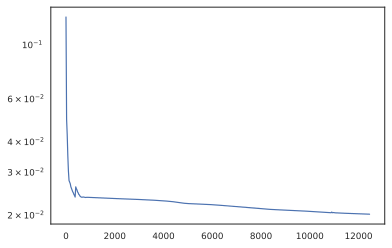

In [45]:
df_ = df_pde[16]
plt.semilogy(df.index, df['loss_mse_output_0'])


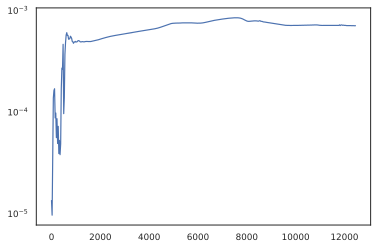

In [46]:
plt.semilogy(df.index, df['loss_reg_output_0'])

(0.0, 2000.0)

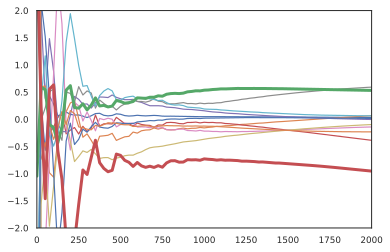

In [93]:
df = df_thr[10]

plt.plot(df.index, df[keys['coeffs']])
plt.plot(df.index, df[keys['coeffs'][2]], lw=3)
plt.plot(df.index, df[keys['coeffs'][5]], lw=3)
plt.ylim([-2, 2])
plt.xlim([0, 2000])

(-2.0, 2.0)

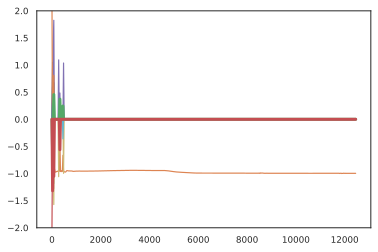

In [103]:
df = df_pde[16]

plt.plot(df.index, df[keys['estimator_coeffs']])
plt.plot(df.index, df[keys['estimator_coeffs'][2]], lw=3)
plt.plot(df.index, df[keys['estimator_coeffs'][5]], lw=3)
plt.ylim([-2, 2])

(-2.0, 2.0)

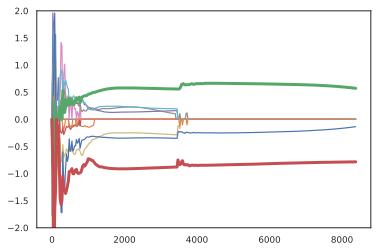

In [142]:
df = df_thr[18]

plt.plot(df.index, df[keys['estimator_coeffs']])
plt.plot(df.index, df[keys['estimator_coeffs'][2]], lw=3)
plt.plot(df.index, df[keys['estimator_coeffs'][5]], lw=3)
plt.ylim([-2, 2])

In [97]:
df = df_thr[10]
print(df[keys['coeffs']].tail(1).to_numpy())
print(df[keys['unscaled_coeffs']].tail(1).to_numpy())
print(df[keys['estimator_coeffs']].tail(1).to_numpy())

[[ 0.          0.          0.53548491  0.          0.         -0.85048485
   0.          0.          0.          0.         -0.04911722  0.        ]]
[[ 0.          0.          0.12237722  0.          0.         -0.97442663
   0.          0.          0.          0.         -0.05855715  0.        ]]
[[ 0.          0.          0.97299129  0.          0.         -0.89875406
   0.          0.          0.          0.         -0.38240802  0.        ]]


In [92]:
df[keys['coeffs']].tail(1).to_numpy()

array([[ 0.        ,  0.        ,  0.53548491,  0.        ,  0.        ,
        -0.85048485,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.04911722,  0.        ]])

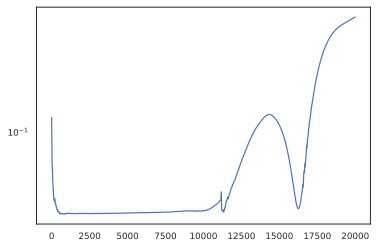

In [105]:
plt.semilogy(df.index, df['remaining_loss_test'])


In [106]:
df['remaining_loss_test'].idxmin()

750

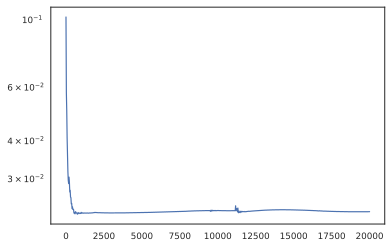

In [107]:
plt.semilogy(df.index, df['remaining_MSE_test'])


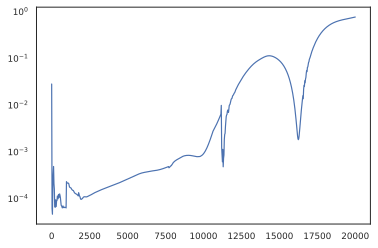

In [108]:
plt.semilogy(df.index, df['remaining_Reg_test'])


In [126]:
sparsity_applied_thr = [np.where(np.diff(np.count_nonzero(df[keys['coeffs']], axis=1)))[0] * 25 for df in df_thr]
sparsity_applied_pde = [np.where(np.diff(np.count_nonzero(df[keys['coeffs']], axis=1)))[0] * 25 for df in df_pde]

In [130]:
len(sparsity_applied_thr)

30

In [131]:
sparsity_applied_thr.reshape(6, 5)


AttributeError: 'list' object has no attribute 'reshape'

In [128]:
sparsity_applied_pde

[array([2075]),
 array([1600]),
 array([1600]),
 array([2250]),
 array([1925]),
 array([2025]),
 array([1875]),
 array([1925]),
 array([1300]),
 array([1175]),
 array([1150, 1250, 1300, 2600, 2650, 3000, 3050]),
 array([2750]),
 array([1075]),
 array([700]),
 array([1675]),
 array([575]),
 array([375, 475, 525]),
 array([900]),
 array([1450]),
 array([800]),
 array([950]),
 array([ 650,  700, 4700, 4750]),
 array([ 725, 7425]),
 array([1150]),
 array([ 525,  575,  625,  675, 1175, 1225, 1325, 1425, 1475, 1525, 1575]),
 array([ 675, 2125, 2175]),
 array([625, 875]),
 array([1100]),
 array([ 700,  750,  800, 6000]),
 array([600])]